## Razorback Logo Detector
- **Objective:** flag Etsy product images that contain the officially licensed Razorback logo so the compliance team can follow up with vendors.
- **Dataset:** 56 manually downloaded Etsy photos + the official mark. Images were labeled into `official` and `not_official` folders, then stratified into 32 train / 12 validation / 12 test items under the standard `ImageFolder` directory structure (`./train`, `./valid`, `./test`).
- **Preprocessing:** every pipeline ends with `Resize((500, 500))` per the project rules, after optional augmentations (cropping/flipping/rotation) meant to fight overfitting on the tiny dataset.




In [1]:
# 1: import all libraries we need and set the device (CPU or GPU)
# This matches the imports from the in-class CNN examples.

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# choose GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [2]:
# 2: set up the data folder paths and basic training settings

data_dir  = "./Data"          # main folder with train / valid / test

train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
test_dir  = data_dir + "/test"

img_size      = 500           # project requirement (final resize to 500x500)
batch_size    = 8             # how many images per batch
num_epochs    = 20            # how many passes through the training data
learning_rate = 0.001         # learning rate for Adam optimizer

# set random seed so results are (mostly) reproducible
torch.manual_seed(1)


In [3]:
# 3: define image transformations (preprocessing + augmentation)

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),   # resize all images to 500x500
    transforms.RandomHorizontalFlip(),         # randomly flip images left/right
    transforms.RandomRotation(10),             # small random rotation
    transforms.ToTensor()                      # convert PIL image to PyTorch tensor
])

valid_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),   # just resize for valid and test
    transforms.ToTensor()
])


In [4]:
# 4: load the images from the folders using ImageFolder

train_dataset = ImageFolder(train_dir, transform=train_transform)
valid_dataset = ImageFolder(valid_dir, transform=valid_transform)
test_dataset  = ImageFolder(test_dir,  transform=valid_transform)

print("Classes:", train_dataset.classes)
print("Train size:", len(train_dataset))
print("Valid size:", len(valid_dataset))
print("Test size:",  len(test_dataset))


Classes: ['not_official', 'official']
Train size: 32
Valid size: 12
Test size: 12


In [5]:
# 5: wrap the datasets in DataLoader objects
# This is the same pattern as in the notes: DataLoader handles batching and shuffling.

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dl  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


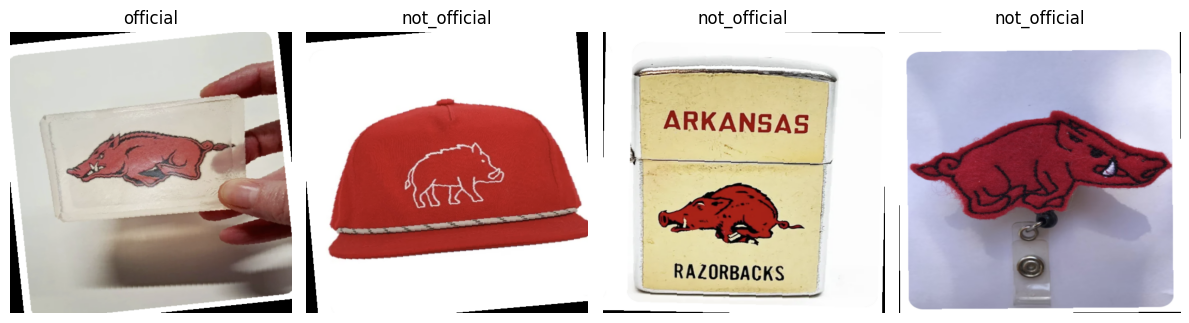

In [6]:
# 6: grab one batch from the training loader and plot a few images
# sanity check to make sure data + labels look correct.

images, labels = next(iter(train_dl))

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    img = images[i].permute(1, 2, 0)   # change from (C,H,W) to (H,W,C) for plotting
    axes[i].imshow(img)
    axes[i].set_title(train_dataset.classes[labels[i]])  # show class name
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [7]:
# 7: build the convolutional part of the CNN using nn.Sequential
# This follows the same structure as the in-class CNN:
# conv -> relu -> pool -> conv -> relu -> pool -> conv -> relu -> pool -> flatten

model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5, padding=2),   # conv1: 3 input channels (RGB), 32 filters
    nn.ReLU(),
    nn.MaxPool2d(2),                              # pool1: downsample 2x

    nn.Conv2d(32, 64, kernel_size=5, padding=2),  # conv2
    nn.ReLU(),
    nn.MaxPool2d(2),                              # pool2

    nn.Conv2d(64, 128, kernel_size=3, padding=1), # conv3
    nn.ReLU(),
    nn.MaxPool2d(2),                              # pool3

    nn.Flatten()                                  # flatten feature maps into a vector
)

# check the flattened dimension by passing a dummy image through the model
with torch.no_grad():
    x = torch.ones(1, 3, img_size, img_size)      # fake input: batch of 1 image
    flat_dim = model(x).shape[1]                  # number of features after flatten
flat_dim


492032

In [8]:
# 8: add the fully connected layers to the Sequential model

model.add_module("fc1", nn.Linear(flat_dim, 256))   # first fully connected layer
model.add_module("relu4", nn.ReLU())
model.add_module("dropout", nn.Dropout(0.5))        # dropout to reduce overfitting
model.add_module("fc2", nn.Linear(256, 2))          # output layer: 2 classes

# move the whole model to the correct device (CPU or GPU)
model = model.to(device)
model


Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=492032, out_features=256, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [9]:
# 9: set up the loss function and optimizer

criterion = nn.CrossEntropyLoss()                    # standard loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [10]:
# 10: define a training function that loops over epochs
# This follows the same pattern as the in class code:
#   - set model.train()
#   - forward pass
#   - compute loss
#   - backward pass and optimizer step
#   - then evaluate on the validation set.

def train_model(model, num_epochs, train_dl, valid_dl):
    train_loss_hist = []
    valid_loss_hist = []
    train_acc_hist  = []
    valid_acc_hist  = []

    for epoch in range(num_epochs):

        # ----- training phase -----
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()             # reset gradients

            outputs = model(inputs)           # forward pass
            loss = criterion(outputs, labels) # compute loss
            loss.backward()                   # backprop
            optimizer.step()                  # update weights

            # track training performance
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_dl.dataset)
        epoch_train_acc  = running_corrects.double() / len(train_dl.dataset)

        #validation phase 
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():                 # no gradients in eval mode
            for inputs, labels in valid_dl:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_valid_loss = running_loss / len(valid_dl.dataset)
        epoch_valid_acc  = running_corrects.double() / len(valid_dl.dataset)

        # save history for plotting later
        train_loss_hist.append(epoch_train_loss)
        valid_loss_hist.append(epoch_valid_loss)
        train_acc_hist.append(epoch_train_acc.item())
        valid_acc_hist.append(epoch_valid_acc.item())

        # print progress like the lecture code
        print(f"Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {epoch_train_loss:.4f}  Valid Loss: {epoch_valid_loss:.4f}  "
              f"Train Acc: {epoch_train_acc:.4f}  Valid Acc: {epoch_valid_acc:.4f}")

    return train_loss_hist, valid_loss_hist, train_acc_hist, valid_acc_hist


In [11]:
# 11: actually call the training function and train the model
# This will print the loss and accuracy for each epoch for both train and validation sets.

train_loss_hist, valid_loss_hist, train_acc_hist, valid_acc_hist = \
    train_model(model, num_epochs, train_dl, valid_dl)


Epoch 1/20 Train Loss: 3.6079  Valid Loss: 0.6825  Train Acc: 0.5625  Valid Acc: 0.5833
Epoch 2/20 Train Loss: 1.6315  Valid Loss: 0.6977  Train Acc: 0.4375  Valid Acc: 0.5000
Epoch 3/20 Train Loss: 0.7383  Valid Loss: 0.6943  Train Acc: 0.4375  Valid Acc: 0.5000
Epoch 4/20 Train Loss: 0.7044  Valid Loss: 0.6944  Train Acc: 0.4062  Valid Acc: 0.5000
Epoch 5/20 Train Loss: 0.6935  Valid Loss: 0.6923  Train Acc: 0.4375  Valid Acc: 0.5833
Epoch 6/20 Train Loss: 0.6890  Valid Loss: 0.6822  Train Acc: 0.5938  Valid Acc: 0.5833
Epoch 7/20 Train Loss: 0.6774  Valid Loss: 0.6784  Train Acc: 0.6562  Valid Acc: 0.6667
Epoch 8/20 Train Loss: 0.6653  Valid Loss: 0.6798  Train Acc: 0.6250  Valid Acc: 0.5833
Epoch 9/20 Train Loss: 0.6839  Valid Loss: 0.6615  Train Acc: 0.5312  Valid Acc: 0.5000
Epoch 10/20 Train Loss: 0.6790  Valid Loss: 0.6770  Train Acc: 0.5625  Valid Acc: 0.5833
Epoch 11/20 Train Loss: 0.6480  Valid Loss: 0.6924  Train Acc: 0.6875  Valid Acc: 0.5000
Epoch 12/20 Train Loss: 0.6247

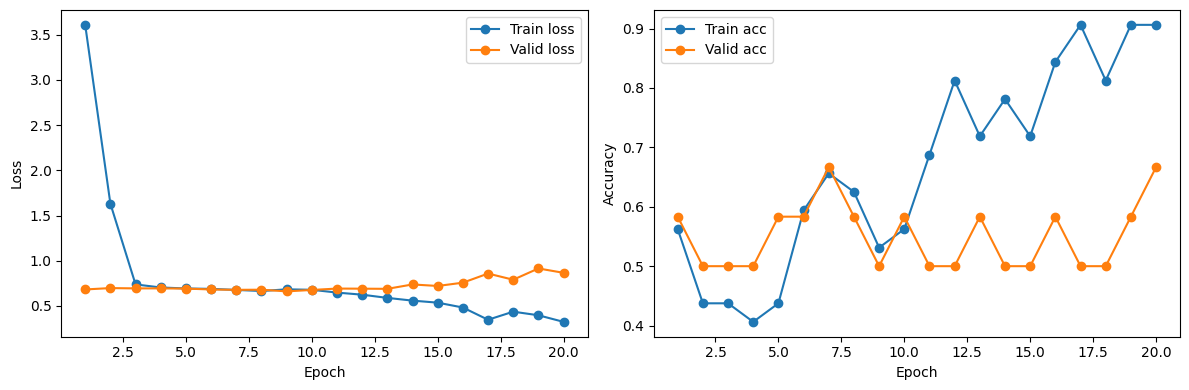

In [12]:
# 12: plot the learning curves for loss and accuracy

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

# left plot: loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_hist, 'o-', label="Train loss")
plt.plot(epochs, valid_loss_hist, 'o-', label="Valid loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# right plot: accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_hist, 'o-', label="Train acc")
plt.plot(epochs, valid_acc_hist, 'o-', label="Valid acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# 13: evaluate the final model on the separate test dataset

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print("Test accuracy:", test_acc)


Test accuracy: 0.5833333333333334


In [14]:
# 14: save the trained model 

filename = f"Group_4_CNN_FullModel.ph"

torch.save(model, filename)
print("Saved model file:", filename)


Saved model file: Group_4_CNN_FullModel.ph
